In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import random
import glob
import warnings
from os import walk
from datetime import date

warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [2]:
import tensorflow as tf


In [3]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(tf.__version__, "Num GPUs Available: ", len(physical_devices))
if(len(physical_devices)>0):
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    

2.0.0 Num GPUs Available:  0


In [23]:
BATCH_SIZE = 10
num_epochs = 5
img_dim = 300

# Rescale image values to 0 - 255
train = ImageDataGenerator(rescale = 1./255)
validation = ImageDataGenerator(rescale = 1./255)
test = ImageDataGenerator(rescale = 1./255)

# Retrieve dataset from directory
train_data = train.flow_from_directory(directory="../dataset/cat/train/",
                                        target_size=(img_dim,img_dim),
                                        color_mode = "grayscale",
                                        class_mode = "binary",
                                        batch_size=BATCH_SIZE)

validation_data = validation.flow_from_directory(directory="../dataset/cat/validation/",
                                        target_size=(img_dim,img_dim),
                                        color_mode = "grayscale",
                                        class_mode = "binary",
                                        batch_size=BATCH_SIZE)

# Number of steps taken to go through entire dataset
train_steps = np.ceil(train_data.samples / BATCH_SIZE)
val_steps = np.ceil(validation_data.samples / BATCH_SIZE)

print(train_steps,val_steps)


Found 102 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
11.0 3.0


In [24]:
def create_model():
    
    model = keras.models.Sequential()
   
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_dim,img_dim,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    
    model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

In [25]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 149, 149, 32)      128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 149, 149, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 74, 74, 64)       

In [26]:

today = date.today()
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "Saved_models/" + str(today) + "/cat-{epoch:04d}/"
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)


Saved_models/2020-11-19/cat-{epoch:04d}/


In [27]:
# Callbacks to use
mcp_save = ModelCheckpoint(checkpoint_dir, save_best_only=True,
                           monitor='val_loss', mode='min', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, verbose=1, min_lr=0.00001)

# Run the trainer
history = model.fit(x=train_data,
                    epochs=500,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch = train_steps,
                    validation_steps = val_steps,
                    validation_data = validation_data,
                    callbacks=[reduce_lr, mcp_save])


Epoch 1/500
11/11 [==============================] - ETA: 0s - loss: 0.9239 - accuracy: 0.7745
Epoch 00001: val_loss improved from inf to 0.63986, saving model to Saved_models/2020-11-19/cat-0001
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Saved_models/2020-11-19/cat-0001/assets
11/11 [==============================] - 3s 227ms/step - loss: 0.9239 - accuracy: 0.7745 - val_loss: 0.6399 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 2/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.3936 - accuracy: 0.8889
Epoch 00002: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 30ms/step - loss: 0.4611 - accuracy: 0.8725 - val_loss: 1.0153 - val_accuracy: 0.1852 - lr: 0.0010
Epoch 3/500
10/11 [==========================>...] - ETA: 0s - loss: 0.3845 - accuracy: 0.8700
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_loss did not improve f

Epoch 26/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0886 - accuracy: 0.9556
Epoch 00026: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 30ms/step - loss: 0.0900 - accuracy: 0.9510 - val_loss: 2.5341 - val_accuracy: 0.2963 - lr: 1.0000e-05
Epoch 27/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0861 - accuracy: 0.9600
Epoch 00027: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 28ms/step - loss: 0.1065 - accuracy: 0.9510 - val_loss: 2.7664 - val_accuracy: 0.2593 - lr: 1.0000e-05
Epoch 28/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1758 - accuracy: 0.9500
Epoch 00028: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 29ms/step - loss: 0.1844 - accuracy: 0.9412 - val_loss: 2.6830 - val_accuracy: 0.2593 - lr: 1.0000e-05
Epoch 29/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1443 - accuracy: 0.9500
Epoch 00029: val_loss 

Epoch 54/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0804 - accuracy: 0.9900
Epoch 00054: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 28ms/step - loss: 0.0788 - accuracy: 0.9902 - val_loss: 1.2486 - val_accuracy: 0.4815 - lr: 1.0000e-05
Epoch 55/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1525 - accuracy: 0.9300
Epoch 00055: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 29ms/step - loss: 0.1519 - accuracy: 0.9314 - val_loss: 1.2506 - val_accuracy: 0.4815 - lr: 1.0000e-05
Epoch 56/500
11/11 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9510
Epoch 00056: val_loss did not improve from 0.63986
11/11 [==============================] - 0s 30ms/step - loss: 0.1158 - accuracy: 0.9510 - val_loss: 1.0825 - val_accuracy: 0.5185 - lr: 1.0000e-05
Epoch 57/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0898 - accuracy: 0.9500
Epoch 00057: val_loss 

10/11 [==========================>...] - ETA: 0s - loss: 0.0994 - accuracy: 0.9500
Epoch 00106: val_loss did not improve from 0.28255
11/11 [==============================] - 0s 29ms/step - loss: 0.0980 - accuracy: 0.9510 - val_loss: 0.3554 - val_accuracy: 0.7778 - lr: 1.0000e-05
Epoch 107/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0803 - accuracy: 0.9600
Epoch 00107: val_loss did not improve from 0.28255
11/11 [==============================] - 0s 30ms/step - loss: 0.0787 - accuracy: 0.9608 - val_loss: 0.3732 - val_accuracy: 0.8148 - lr: 1.0000e-05
Epoch 108/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1061 - accuracy: 0.9400
Epoch 00108: val_loss improved from 0.28255 to 0.28126, saving model to Saved_models/2020-11-19/cat-0108
INFO:tensorflow:Assets written to: Saved_models/2020-11-19/cat-0108/assets
11/11 [==============================] - 2s 183ms/step - loss: 0.1045 - accuracy: 0.9412 - val_loss: 0.2813 - val_accuracy: 0.8889 - lr: 1.0000e-05

Epoch 133/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0845 - accuracy: 0.9667
Epoch 00133: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 30ms/step - loss: 0.0792 - accuracy: 0.9706 - val_loss: 0.3273 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 134/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1030 - accuracy: 0.9400
Epoch 00134: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 29ms/step - loss: 0.1010 - accuracy: 0.9412 - val_loss: 0.2880 - val_accuracy: 0.8889 - lr: 1.0000e-05
Epoch 135/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0599 - accuracy: 0.9600
Epoch 00135: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 28ms/step - loss: 0.0760 - accuracy: 0.9510 - val_loss: 0.2949 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 136/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1288 - accuracy: 0.9500
Epoch 00136: val_l

Epoch 161/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1557 - accuracy: 0.9400
Epoch 00161: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 30ms/step - loss: 0.1575 - accuracy: 0.9412 - val_loss: 0.3099 - val_accuracy: 0.7778 - lr: 1.0000e-05
Epoch 162/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0819 - accuracy: 0.9700
Epoch 00162: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 29ms/step - loss: 0.0881 - accuracy: 0.9608 - val_loss: 0.3094 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 163/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1430 - accuracy: 0.9600
Epoch 00163: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 29ms/step - loss: 0.1663 - accuracy: 0.9510 - val_loss: 0.3208 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 164/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0863 - accuracy: 0.9600
Epoch 00164: val_l

Epoch 189/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0542 - accuracy: 0.9800
Epoch 00189: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 28ms/step - loss: 0.0532 - accuracy: 0.9804 - val_loss: 0.2607 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 190/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0718 - accuracy: 0.9800
Epoch 00190: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 29ms/step - loss: 0.0704 - accuracy: 0.9804 - val_loss: 0.2733 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 191/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0864 - accuracy: 0.9444
Epoch 00191: val_loss did not improve from 0.18576
11/11 [==============================] - 0s 29ms/step - loss: 0.0791 - accuracy: 0.9510 - val_loss: 0.3459 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 192/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0650 - accuracy: 0.9800
Epoch 00192: val_l

Epoch 216/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0448 - accuracy: 0.9900
Epoch 00216: val_loss did not improve from 0.11925
11/11 [==============================] - 0s 28ms/step - loss: 0.0439 - accuracy: 0.9902 - val_loss: 0.2256 - val_accuracy: 0.8889 - lr: 1.0000e-05
Epoch 217/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0634 - accuracy: 0.9900
Epoch 00217: val_loss did not improve from 0.11925
11/11 [==============================] - 0s 29ms/step - loss: 0.0622 - accuracy: 0.9902 - val_loss: 0.2637 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 218/500
11/11 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9706
Epoch 00218: val_loss did not improve from 0.11925
11/11 [==============================] - 0s 29ms/step - loss: 0.0602 - accuracy: 0.9706 - val_loss: 0.2322 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 219/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0786 - accuracy: 0.9600
Epoch 00219: val_l

Epoch 244/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0431 - accuracy: 0.9800
Epoch 00244: val_loss did not improve from 0.11916
11/11 [==============================] - 0s 29ms/step - loss: 0.0478 - accuracy: 0.9804 - val_loss: 0.2544 - val_accuracy: 0.8889 - lr: 1.0000e-05
Epoch 245/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0524 - accuracy: 0.9900
Epoch 00245: val_loss improved from 0.11916 to 0.11418, saving model to Saved_models/2020-11-19/cat-0245
INFO:tensorflow:Assets written to: Saved_models/2020-11-19/cat-0245/assets
11/11 [==============================] - 2s 185ms/step - loss: 0.0514 - accuracy: 0.9902 - val_loss: 0.1142 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 246/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1335 - accuracy: 0.9600
Epoch 00246: val_loss did not improve from 0.11418
11/11 [==============================] - 0s 28ms/step - loss: 0.1309 - accuracy: 0.9608 - val_loss: 0.2226 - val_accuracy: 0.8889 - 

Epoch 271/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0829 - accuracy: 0.9700
Epoch 00271: val_loss did not improve from 0.10134
11/11 [==============================] - 0s 29ms/step - loss: 0.0815 - accuracy: 0.9706 - val_loss: 0.2222 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 272/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1104 - accuracy: 0.9700
Epoch 00272: val_loss did not improve from 0.10134
11/11 [==============================] - 0s 29ms/step - loss: 0.1087 - accuracy: 0.9706 - val_loss: 0.2029 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 273/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0595 - accuracy: 0.9700
Epoch 00273: val_loss did not improve from 0.10134
11/11 [==============================] - 0s 29ms/step - loss: 0.0584 - accuracy: 0.9706 - val_loss: 0.2194 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 274/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0467 - accuracy: 0.9800
Epoch 00274: val_l

Epoch 299/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0542 - accuracy: 0.9800
Epoch 00299: val_loss did not improve from 0.10134
11/11 [==============================] - 0s 29ms/step - loss: 0.0531 - accuracy: 0.9804 - val_loss: 0.3060 - val_accuracy: 0.8889 - lr: 1.0000e-05
Epoch 300/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0487 - accuracy: 0.9900
Epoch 00300: val_loss did not improve from 0.10134
11/11 [==============================] - 0s 29ms/step - loss: 0.0513 - accuracy: 0.9902 - val_loss: 0.2025 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 301/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0705 - accuracy: 0.9700
Epoch 00301: val_loss did not improve from 0.10134
11/11 [==============================] - 0s 29ms/step - loss: 0.0691 - accuracy: 0.9706 - val_loss: 0.2069 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 302/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0455 - accuracy: 0.9800
Epoch 00302: val_l

Epoch 326/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0496 - accuracy: 0.9800
Epoch 00326: val_loss did not improve from 0.06580
11/11 [==============================] - 0s 29ms/step - loss: 0.0509 - accuracy: 0.9804 - val_loss: 0.2918 - val_accuracy: 0.8889 - lr: 1.0000e-05
Epoch 327/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0560 - accuracy: 0.9800
Epoch 00327: val_loss did not improve from 0.06580
11/11 [==============================] - 0s 29ms/step - loss: 0.0549 - accuracy: 0.9804 - val_loss: 0.1917 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 328/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0534 - accuracy: 0.9800
Epoch 00328: val_loss did not improve from 0.06580
11/11 [==============================] - 0s 30ms/step - loss: 0.0524 - accuracy: 0.9804 - val_loss: 0.2000 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 329/500
10/11 [==========================>...] - ETA: 0s - loss: 0.1128 - accuracy: 0.9400
Epoch 00329: val_l

Epoch 354/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0431 - accuracy: 0.9800
Epoch 00354: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 28ms/step - loss: 0.0422 - accuracy: 0.9804 - val_loss: 0.3046 - val_accuracy: 0.8889 - lr: 1.0000e-05
Epoch 355/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0371 - accuracy: 0.9800
Epoch 00355: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 29ms/step - loss: 0.0368 - accuracy: 0.9804 - val_loss: 0.2048 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 356/500
11/11 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9706
Epoch 00356: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 30ms/step - loss: 0.0603 - accuracy: 0.9706 - val_loss: 0.1565 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 357/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0688 - accuracy: 0.9700
Epoch 00357: val_l

Epoch 382/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.1043 - accuracy: 0.9556
Epoch 00382: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 31ms/step - loss: 0.0964 - accuracy: 0.9608 - val_loss: 0.2053 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 383/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0875 - accuracy: 0.9556
Epoch 00383: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 31ms/step - loss: 0.0783 - accuracy: 0.9608 - val_loss: 0.0833 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 384/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0320 - accuracy: 0.9889
Epoch 00384: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 31ms/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.3419 - val_accuracy: 0.8519 - lr: 1.0000e-05
Epoch 385/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0445 - accuracy: 0.9778
Epoch 00385: val_l

Epoch 410/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0352 - accuracy: 0.9900
Epoch 00410: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 31ms/step - loss: 0.0345 - accuracy: 0.9902 - val_loss: 0.1033 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 411/500
11/11 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9804
Epoch 00411: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 30ms/step - loss: 0.0568 - accuracy: 0.9804 - val_loss: 0.1754 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 412/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0287 - accuracy: 0.9900
Epoch 00412: val_loss did not improve from 0.05042
11/11 [==============================] - 0s 30ms/step - loss: 0.0281 - accuracy: 0.9902 - val_loss: 0.1722 - val_accuracy: 0.9259 - lr: 1.0000e-05
Epoch 413/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0309 - accuracy: 1.0000
Epoch 00413: val_l

Epoch 438/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0449 - accuracy: 0.9889
Epoch 00438: val_loss did not improve from 0.04972
11/11 [==============================] - 0s 31ms/step - loss: 0.0405 - accuracy: 0.9902 - val_loss: 0.1369 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 439/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0271 - accuracy: 0.9889
Epoch 00439: val_loss did not improve from 0.04972
11/11 [==============================] - 0s 31ms/step - loss: 0.0467 - accuracy: 0.9804 - val_loss: 0.1462 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 440/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0462 - accuracy: 0.9778
Epoch 00440: val_loss did not improve from 0.04972
11/11 [==============================] - 0s 31ms/step - loss: 0.0410 - accuracy: 0.9804 - val_loss: 0.0636 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 441/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0661 - accuracy: 0.9556
Epoch 00441: val_l

Epoch 466/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0300 - accuracy: 0.9889
Epoch 00466: val_loss did not improve from 0.04762
11/11 [==============================] - 0s 30ms/step - loss: 0.0343 - accuracy: 0.9804 - val_loss: 0.1322 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 467/500
10/11 [==========================>...] - ETA: 0s - loss: 0.0320 - accuracy: 0.9900
Epoch 00467: val_loss did not improve from 0.04762
11/11 [==============================] - 0s 29ms/step - loss: 0.0318 - accuracy: 0.9902 - val_loss: 0.1318 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 468/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0384 - accuracy: 0.9889
Epoch 00468: val_loss did not improve from 0.04762
11/11 [==============================] - 0s 30ms/step - loss: 0.0377 - accuracy: 0.9902 - val_loss: 0.1306 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 469/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0349 - accuracy: 0.9889
Epoch 00469: val_l

Epoch 494/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000
Epoch 00494: val_loss improved from 0.03775 to 0.03536, saving model to Saved_models/2020-11-19/cat-0494
INFO:tensorflow:Assets written to: Saved_models/2020-11-19/cat-0494/assets
11/11 [==============================] - 2s 191ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 495/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0214 - accuracy: 1.0000
Epoch 00495: val_loss did not improve from 0.03536
11/11 [==============================] - 0s 30ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.1384 - val_accuracy: 0.9630 - lr: 1.0000e-05
Epoch 496/500
 9/11 [=======================>......] - ETA: 0s - loss: 0.0136 - accuracy: 1.0000
Epoch 00496: val_loss did not improve from 0.03536
11/11 [==============================] - 0s 31ms/step - loss: 0.0207 - accuracy: 0.9902 - val_loss: 0.1203 - val_accuracy: 0.9630 - 

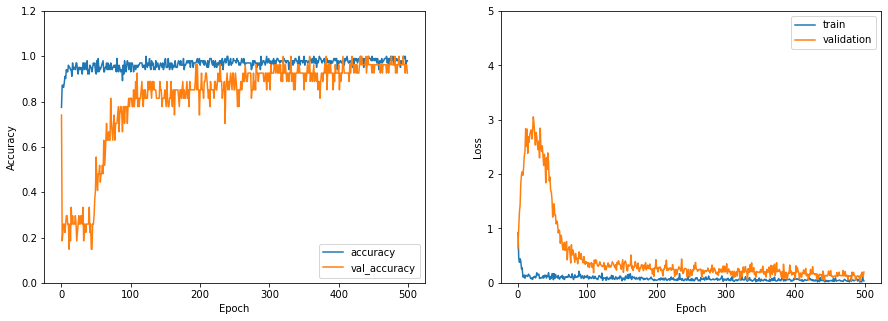

In [28]:
# Plot accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.2])
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')
plt.show()

In [32]:

rows = 2
cols = 6
no = 1
def makePredict(pic, loaded_model):
    global no

    test_img = image.load_img(pic, color_mode="grayscale", target_size=(img_dim, img_dim))
    
    test_img_arr = image.img_to_array(test_img)
    test_img_arr = np.array([test_img_arr]) # Convert single image to batch
    test_img_arr /= 255.0 # Normalize array to 0-1

    r = loaded_model.predict(test_img_arr)

    confidence =  "%5.2f"%(100*r)
    plt.subplot(rows, cols, no)
    no += 1
    
    plt.title(label=confidence + "%")
    plt.imshow(test_img)

last model: Saved_models/2020-11-19/cat-0482


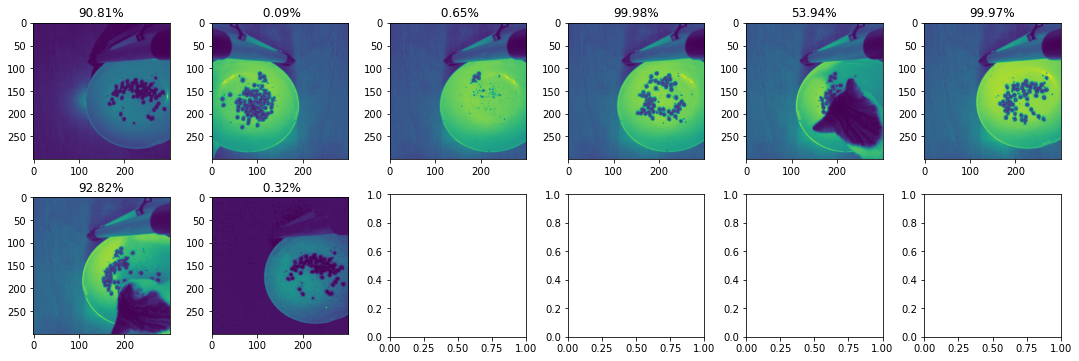

In [33]:
# Load most accurate model
mpath = 'Saved_models/' + str(today)
savedModels = [f for f in glob.glob(mpath + "/bowl-*")]
savedModels.sort()
lastModel = savedModels[-2]
print("last model: " + lastModel)

# Model is saved as a directory with an assest folder variables folder, and a .pb file
# Load in the best model
loaded_model = tf.keras.models.load_model(lastModel)

testfiles = [f for f in glob.glob("../dataset/cat/test/*.jpeg")]
testtotal = len(testfiles) 
fig,ax = plt.subplots(rows,cols, figsize = [15,5])
fig.tight_layout()
pn = 1
for testpic in testfiles:
        global pn
        makePredict(testpic,loaded_model)
        pn +=1